##Setup

In [0]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import colorConverter
from PIL import Image
import os
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch


# Data import

In [0]:
# inherit the origin mido class
class MidiFile(mido.MidiFile):

    def __init__(self, filename):

        mido.MidiFile.__init__(self, filename)
        self.sr = 10
        self.meta = {}
        self.events = self.get_events()

    def get_events(self):
        mid = self
#         print(mid)

        # There is > 16 channel in midi.tracks. However there is only 16 channel related to "music" events.
        # We store music events of 16 channel in the list "events" with form [[ch1],[ch2]....[ch16]]
        # Lyrics and meta data used a extra channel which is not include in "events"

        events = [[] for x in range(16)]

        # Iterate all event in the midi and extract to 16 channel form
        for track in mid.tracks:
            for msg in track:
                try:
                    channel = msg.channel
                    events[channel].append(msg)
                except AttributeError:
                    try:
                        if type(msg) != type(mido.UnknownMetaMessage):
                            self.meta[msg.type] = msg.dict()
                        else:
                            pass
                    except:
                        print("error",type(msg))

        return events

    def get_roll(self):
        events = self.get_events()
        # Identify events, then translate to piano roll
        # choose a sample ratio(sr) to down-sample through time axis
        sr = self.sr

        # compute total length in tick unit
        length = self.get_total_ticks()

        # allocate memory to numpy array
        roll = np.zeros((16, 128, length // sr), dtype="int8")

        # use a register array to save the state(no/off) for each key
        note_register = [int(-1) for x in range(128)]

        # use a register array to save the state(program_change) for each channel
        timbre_register = [1 for x in range(16)]


        for idx, channel in enumerate(events):

            time_counter = 0
            volume = 100
            # Volume would change by control change event (cc) cc7 & cc11
            # Volume 0-100 is mapped to 0-127

#             print("channel", idx, "start")
            for msg in channel:
                if msg.type == "control_change":
                    if msg.control == 7:
                        volume = msg.value
                        # directly assign volume
                    if msg.control == 11:
                        volume = volume * msg.value // 127
                        # change volume by percentage
                    # print("cc", msg.control, msg.value, "duration", msg.time)

                if msg.type == "program_change":
                    timbre_register[idx] = msg.program
#                     print("channel", idx, "pc", msg.program, "time", time_counter, "duration", msg.time)



                if msg.type == "note_on":
#                     print("on ", msg.note, "time", time_counter, "duration", msg.time, "velocity", msg.velocity)
                    note_on_start_time = time_counter // sr
                    note_on_end_time = (time_counter + msg.time) // sr
                    intensity = volume * msg.velocity // 127



					# When a note_on event *ends* the note start to be play 
					# Record end time of note_on event if there is no value in register
					# When note_off event happens, we fill in the color
                    if note_register[msg.note] == -1:
                        note_register[msg.note] = (note_on_end_time,intensity)
                    else:
					# When note_on event happens again, we also fill in the color
                        old_end_time = note_register[msg.note][0]
                        old_intensity = note_register[msg.note][1]
                        roll[idx, msg.note, old_end_time: note_on_end_time] = old_intensity
                        note_register[msg.note] = (note_on_end_time,intensity)


                if msg.type == "note_off":
#                     print("off", msg.note, "time", time_counter, "duration", msg.time, "velocity", msg.velocity)
                    note_off_start_time = time_counter // sr
                    note_off_end_time = (time_counter + msg.time) // sr
                    note_on_end_time = note_register[msg.note][0]
                    intensity = note_register[msg.note][1]
					# fill in color
                    roll[idx, msg.note, note_on_end_time:note_off_end_time] = intensity

                    note_register[msg.note] = -1  # reinitialize register

                time_counter += msg.time

                # TODO : velocity -> done, but not verified
                # TODO: Pitch wheel
                # TODO: Channel - > Program Changed / Timbre catagory
                # TODO: real time scale of roll

            # if there is a note not closed at the end of a channel, close it
            for key, data in enumerate(note_register):
                if data != -1:
                    note_on_end_time = data[0]
                    intensity = data[1]
                    # print(key, note_on_end_time)
                    note_off_start_time = time_counter // sr
                    roll[idx, key, note_on_end_time:] = intensity
                note_register[idx] = -1

        return roll

    def get_roll_image(self):
        roll = self.get_roll()
        plt.ioff()

        K = 16

        transparent = colorConverter.to_rgba('black')
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / K, 1, 1)), alpha=1) for i in range(K)]
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, colors[i]], 128) for i in
                 range(K)]

        for i in range(K):
            cmaps[i]._init()  # create the _lut array, with rgba values
            # create your alpha array and fill the colormap with them.
            # here it is progressive, but you can create whathever you want
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            cmaps[i]._lut[:, -1] = alphas

        fig = plt.figure(figsize=(15, 3))
        a1 = fig.add_subplot(111)
        a1.axis("equal")
        a1.set_facecolor("black")

        array = []

        for i in range(K):
            try:
                img = a1.imshow(roll[i], interpolation='nearest', cmap=cmaps[i], aspect='auto')
                array.append(img.get_array())
            except IndexError:
                pass
        return array

    def draw_roll(self,filename):


        roll = self.get_roll()

        # build and set fig obj
        plt.ioff()
        fig = plt.figure(figsize=(15, 5))
        a1 = fig.add_subplot(111)
        a1.axis("equal")
#         a1.set_facecolor("black")

        # change unit of time axis from tick to second
        tick = self.get_total_ticks()
        second = mido.tick2second(tick, self.ticks_per_beat, self.get_tempo())
#         print(second)
        if second > 10:
            x_label_period_sec = second // 10
        else:
            x_label_period_sec = second / 10  # ms
#         print(x_label_period_sec)
        x_label_interval = mido.second2tick(x_label_period_sec, self.ticks_per_beat, self.get_tempo()) / self.sr
#         print(x_label_interval)
        plt.xticks([int(x * x_label_interval) for x in range(20)], [round(x * x_label_period_sec, 2) for x in range(20)])

        # change scale and label of y axis
        plt.yticks([y*16 for y in range(8)], [y*16 for y in range(8)])

        # build colors
        channel_nb = 1
        transparent = colorConverter.to_rgba('black')
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / channel_nb, 1, 1)), alpha=1) for i in range(channel_nb)]
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, colors[i]], 128) for i in
                 range(channel_nb)]

        # build color maps
        for i in range(channel_nb):
            cmaps[i]._init()
            # create your alpha array and fill the colormap with them.
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            # create the _lut array, with rgba values
            cmaps[i]._lut[:, -1] = alphas


        # draw piano roll and stack image on a1
        for i in range(channel_nb):
            try:
                a1.imshow(roll[i], origin="lower", interpolation='nearest', cmap=cmaps[i], aspect='auto')
            except IndexError:
                pass

        # draw color bar

#         colors = [mpl.colors.hsv_to_rgb((i / channel_nb, 1, 1)) for i in range(channel_nb)]
#         cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', colors, 16)
#         a2 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
#         cbar = mpl.colorbar.ColorbarBase(a2, cmap=cmap,
#                                         orientation='horizontal',
#                                         ticks=list(range(16)))

        # show piano roll
#         plt.draw()
#         plt.ion()
        plt.savefig('.\\maestro-v1.0.0\\IMAGES\\'+ filename)
#         plt.show(block=True)

    def get_tempo(self):
        try:
            return self.meta["set_tempo"]["tempo"]
        except:
            return 500000

    def get_total_ticks(self):
        max_ticks = 0
        for channel in range(16):
            ticks = sum(msg.time for msg in self.events[channel])
            if ticks > max_ticks:
                max_ticks = ticks
        return max_ticks

In [2]:
# Unzip IMAGES file

!unzip IMAGES2.zip

Archive:  IMAGES2.zip
   creating: IMAGES2/
  inflating: IMAGES2/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1.png  
  inflating: IMAGES2/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--2.png  
  inflating: IMAGES2/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--3.png  
  inflating: IMAGES2/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--5.png  
  inflating: IMAGES2/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--1.png  
  inflating: IMAGES2/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--2.png  
  inflating: IMAGES2/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--4.png  
  inflating: IMAGES2/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--5.png  
  inflating: IMAGES2/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--2.png  
  inflating: IMAGES2/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--3.png  
  inflating: IMAGES2/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--4.png  

In [3]:
%pwd

'/content'

# Doing werk

In [17]:
SHORT = True

imgpath = '/content/IMAGES2/'

filenames = []

for i in os.listdir(imgpath):
  filenames.append(i)
print(filenames[0])
    
if SHORT:
  with open('short_song_list.csv','r') as songfile:
    for line in songfile:
      filenames = line.split(',')
    
print(filenames[0])

MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--2.png
MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--3.png


(777600, 4)


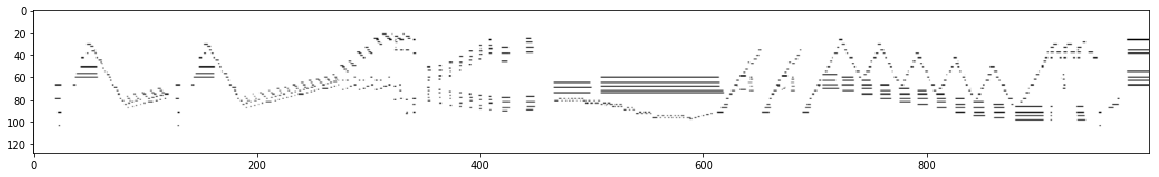

In [18]:

image = Image.open(imgpath+filenames[0])
print(np.asarray(image.getdata()).shape)
loader = transforms.Compose([transforms.Resize((172,3600)),
                             transforms.CenterCrop((128,2700)),
                             transforms.Resize((128,1000)),
                             transforms.Grayscale(num_output_channels=1),
                             transforms.ToTensor()])


def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
#     image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    
    return image  #assumes that you're using GPU

image = loader(image).float()

plt.figure(figsize=(20,5))
plt.imshow(image[0],cmap='gray')
plt.show()

In [0]:

# image = Image.open(imgpath+filenames[0])
# loader = transforms.Compose([transforms.Resize((360,640)),
#                              transforms.CenterCrop((275,480)),
#                              transforms.Grayscale(num_output_channels=1),
#                              transforms.ToTensor()])


# def image_loader(image_name):
#     """load image, returns cuda tensor"""
#     image = Image.open(image_name)
#     image = loader(image).float()
#     image = Variable(image, requires_grad=True)
# #     image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    
#     return image  #assumes that you're using GPU

# image = loader(image).float()

# plt.imshow(image[0],cmap='gray')
# plt.show()

In [19]:
# Get the training set tensors into a list
training_set = []

training_set

for i in filenames:
  try:
    training_set.append(image_loader(imgpath + i))
  except IOError:
    print("Error opening file ",i)
    

Error opening file  



In [21]:
#print(len(training_set[0:1160]))
print(len(training_set[0:525]))

525


(1, 128, 1000)

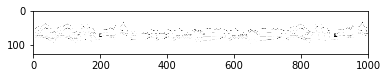

In [22]:
plt.imshow(training_set[100].detach().numpy().squeeze(),cmap='gray')

training_set[0].detach().numpy().shape

In [0]:
# Michael Dataset Extender
class Dataset_Handler(torch.utils.data.Dataset):
  def __init__(self, input_v):
    self.input = input_v


  def __len__(self):
    return len(self.input)

  def __getitem__(self, index):
    return self.input[index]

In [0]:
batch_size = 25

#train_class = Dataset_Handler(training_set[0:1160])
train_class = Dataset_Handler(training_set[0:525])

train = torch.utils.data.DataLoader(train_class, batch_size = batch_size, shuffle = True)


In [2]:

import torch
import torch.optim as optim

# setup the GANs

#WGAN first


# LSGAN implementation

LS_G = torch.nn.Sequential(
    torch.nn.Linear(100, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 512),
    torch.nn.Linear(512 , 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 128*1000),
    torch.nn.Tanh()
)

LS_D = torch.nn.Sequential(
    torch.nn.Linear(128 * 1000, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 512),
    torch.nn.Linear(512 , 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 1),
    torch.nn.Sigmoid()
)

LS_G_solver = optim.RMSprop(LS_G.parameters(), lr=0.00005)
LS_D_solver = optim.RMSprop(LS_D.parameters(), lr=0.00005)

LS_G.cuda()
LS_D.cuda()

print(LS_G)
print(LS_D)

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): Linear(in_features=512, out_features=1024, bias=True)
  (4): ReLU()
  (5): Linear(in_features=1024, out_features=128000, bias=True)
  (6): Tanh()
)
Sequential(
  (0): Linear(in_features=128000, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=1, bias=True)
  (6): Sigmoid()
)


In [0]:

# import torch
# import torch.optim as optim

# # setup the GANs

# #WGAN first


# # LSGAN implementation

# LS_G = torch.nn.Sequential(
#     torch.nn.Linear(100, 256),
#     torch.nn.ReLU(),
#     torch.nn.Linear(256, 512),
#     torch.nn.Linear(512 , 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, 275*480),
#     torch.nn.Tanh()
# )

# LS_D = torch.nn.Sequential(
#     torch.nn.Linear(275 * 480, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, 512),
#     torch.nn.Linear(512 , 256),
#     torch.nn.ReLU(),
#     torch.nn.Linear(256, 1),
#     torch.nn.Sigmoid()
# )

# LS_G_solver = optim.RMSprop(LS_G.parameters(), lr=0.0001)
# LS_D_solver = optim.RMSprop(LS_D.parameters(), lr=0.0001)

# LS_G.cuda()
# # LS_D.cuda()

In [0]:
import torch.nn as nn
criterion = nn.BCELoss()

In [0]:
# Function to train descriminator and return loss
def train_discriminator(real_data, fake_data):
    real_target = real_data_target(batch_size)#.detach() # Added late
    fake_target = fake_data_target(batch_size).detach()
    
    # Calculate error and backpropagate
    prediction_real = LS_D(real_data)
    real_loss = criterion(prediction_real, real_target)

    # Calculate error and backpropagate
    prediction_fake = LS_D(fake_data)
    fake_loss = criterion(prediction_fake, fake_target)
    
    # Reset discriminator gradients and update weights
    total_loss = real_loss + fake_loss
    LS_D_solver.zero_grad()  
    total_loss.backward()
    LS_D_solver.step()
      
    return total_loss

In [0]:
from torch.autograd import Variable

def images_to_vectors(images):
  return images.view(images.size(0), 128*1000)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0), 1, 128, 1000)

def real_data_target(size):
  '''
  Tensor containing ones, with shape = size
  '''
  data = Variable(torch.ones(size, 1))
  if torch.cuda.is_available(): return data.cuda()
  return data

def fake_data_target(size):
  '''
  Tensor containing zeros, with shape = size
  '''
  data = Variable(torch.zeros(size, 1))
  if torch.cuda.is_available(): return data.cuda()
  return data

def noise(size):
  n = Variable(torch.randn(size, 100))
  if torch.cuda.is_available(): return n.cuda() 
  print("Not using cuda for noise")
  return n

# Function to train the generator
def train_generator(fake_data):
    real_target = real_data_target(batch_size)
        
    # Calculate error and backpropagate
    prediction = LS_D(fake_data)
    train_loss = criterion(prediction, real_target)
    
    # Update generator weights with gradients
    LS_G_solver.zero_grad()
    train_loss.backward()
    LS_G_solver.step()

    return train_loss

In [0]:
def plot_errors(err1, err2):
  filename="ERRORS"+str(len(err1))
  x_axis = np.arange(0,len(err1))
  plt.plot(x_axis,err1,label="Discriminator")
  plt.plot(x_axis,err2,label="Generator")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.title("BCELoss per epoch for Vanilla GAN")
  plt.savefig(filename)
  plt.show()

In [0]:

def show_test_images(num_images, epoch=None):
  # Defining pyplot parameters
  #rows = (num_images/5)
  rows=0
  if num_images%5 > 0:
    rows += 1
  #cols = 5
  cols = 1
  fig,ax = plt.subplots(int(rows),int(cols),figsize=(12,6))
  if epoch == None:
    title = "Test images from Generator model"
    filename = "manually_generated_epochs"
  else:
    title = "Test images from Generator model after epoch "+str(epoch)
    filename = "generated_epochs_"+str(epoch)
  fig.suptitle(title,x=0.5,y=0.62)
    
  noise_data = noise(num_images)
  noise_images = LS_G(noise_data)
  
  print(noise_images.detach().sum())
    
  for index,noise_img in enumerate(noise_images):
    plt.subplot(rows,cols,index+1)
    plt.xticks([])
    plt.yticks([])
    
    noise_img = noise_img / 2 + 0.5     # unnormalize    
    npimg = noise_img.cpu().detach().numpy().reshape((128,1000))
    plt.imshow(npimg,cmap='Greys')
  plt.tight_layout()
  plt.savefig(filename)
  plt.show()

In [45]:
# Train the models
# Total number of epochs to train
num_epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

gen_error = []
disc_error = []

for epoch in range(num_epochs):
  temp_disc_err = 0
  temp_gen_err = 0
  temp_err_cnt = 0
  
  for n_batch, real_batch in enumerate(train):
    # train discriminator
    fake_noise = noise(batch_size)
    fake_data = LS_G(fake_noise).to(device)    
    #print("real_batch_shape",real_batch.shape)
    real_data = Variable(images_to_vectors(real_batch)).to(device)
#     real_data = Variable(images_to_vectors(real_batch)).to(device)
    disc_err = train_discriminator(real_data, fake_data)
    temp_disc_err += disc_err

    # train generator
    #fake_noise = noise(batch_size)      
    fake_data = LS_G(fake_noise).to(device)
    gen_err = train_generator(fake_data)
    temp_gen_err += gen_err
    temp_err_cnt += 1

  disc_error.append(temp_disc_err/temp_err_cnt)
  gen_error.append(temp_gen_err/temp_err_cnt)
  
  if (epoch) % 5 == 0 or epoch == (num_epochs-1): 
    print("Last generator error -",gen_error[-1])
    print("Last discriminator error =",disc_error[-1])
    plot_errors(disc_error,gen_error)
    show_test_images(1, epoch)


Output hidden; open in https://colab.research.google.com to view.

tensor(128986.6875, device='cuda:0')


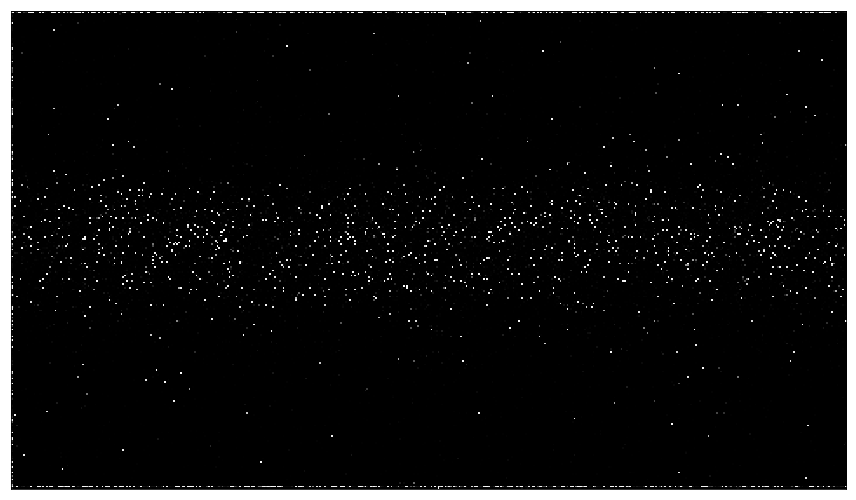

In [0]:
show_test_images(1)

tensor(129008.7344, device='cuda:0')


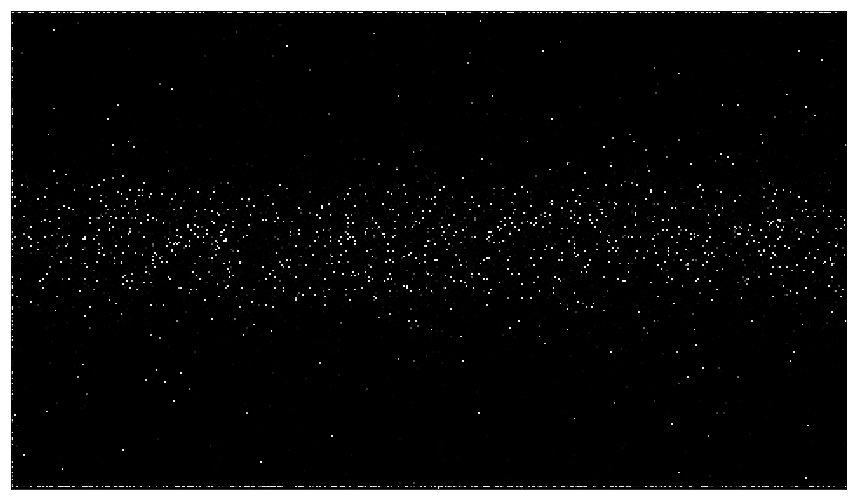

In [0]:
show_test_images(1)

tensor(129906.8125, device='cuda:0')


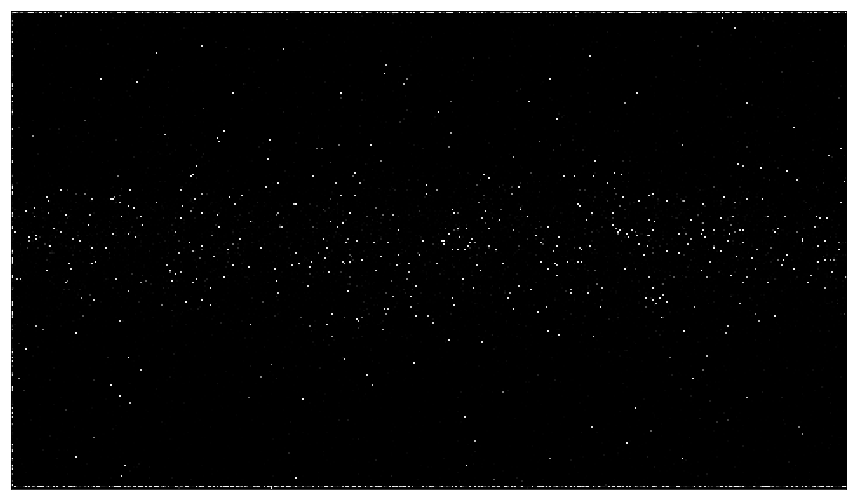

In [29]:
show_test_images(1)

tensor(126105.6406, device='cuda:0')


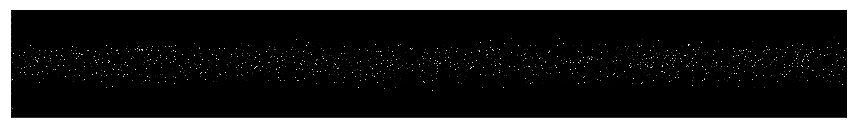

In [37]:
show_test_images(1,"new")

In [1]:
with open('short_song_list.csv','r') as songfile:
  for line in songfile:
    new_list = line.split(',')
print(new_list[0])

MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--3.midi


Empty DataFrame
Columns: [2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--3.midi, 2011/MIDI-Unprocessed_22_R1_2011_MID--AUDIO_R1-D8_12_Track12_wav.midi, 2008/MIDI-Unprocessed_04_R3_2008_01-07_ORIG_MID--AUDIO_04_R3_2008_wav--2.midi, 2008/MIDI-Unprocessed_08_R1_2008_01-05_ORIG_MID--AUDIO_08_R1_2008_wav--5.midi, 2008/MIDI-Unprocessed_09_R3_2008_01-07_ORIG_MID--AUDIO_09_R3_2008_wav--2.midi, 2013/ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_06_R1_2013_wav--3.midi, 2014/MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--2.midi, 2008/MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--3.midi, 2008/MIDI-Unprocessed_11_R2_2008_01-05_ORIG_MID--AUDIO_11_R2_2008_wav--2.midi, 2017/MIDI-Unprocessed_070_PIANO070_MID--AUDIO-split_07-08-17_Piano-e_1-02_wav--2.midi, 2014/MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_10_R1_2014_wav--1.midi, 2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_15_R1_2015_wav--2.midi, 2009/MIDI-Unprocessed_11_R1_2009_01-05_ORIG_MID--AUDIO_11_